# Quantum Syncronization with ML - Master Equation Model

## Importing libraries

In [8]:
import numpy as np
import pandas as pd
from scipy.linalg import expm
from scipy.sparse import kron, identity
from scipy.sparse.linalg import eigsh
from matplotlib import pyplot as plt
from qutip import *
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error
import warnings
from random import randint

## Collecting the data

In [7]:
def data_masterEquation(w1=1, f=0.01, t_max = 400):
    w2 = 1
    g0 = 0.05
    g1 = (w1**3)*g0
    g2 = (w2**3)*g0
    g11 = np.sqrt(g1*g1)
    g12 = np.sqrt(g1*g2)
    g21 = np.sqrt(g2*g1)
    g22 = np.sqrt(g2*g2)
    a = 1.0
    n = 0.0

    sp = np.array([[0, 1], [0, 0]])
    sm = np.array([[0, 0], [1, 0]])
    sp1 = np.kron(sp, np.identity(2))
    sp2 = np.kron(np.identity(2), sp)
    sm1 = np.kron(sm, np.identity(2))
    sm2 = np.kron(np.identity(2), sm)
    sz1 = np.kron(np.array([[1, 0], [0, -1]])/2, np.identity(2))
    sz2 = np.kron(np.identity(2), np.array([[1, 0], [0, -1]])/2)
    hs1 = w1*sz1
    hs2 = w2*sz2
    hdd = f*(np.dot(sp1, sm2) + np.dot(sp2, sm1))

    cohlind = -1j*(np.kron((hs1 + hs2), np.identity(4)) - np.kron(np.identity(4), (hs1 + hs2))) \
              - 1j*(np.kron(hdd, np.identity(4)) - np.kron(np.identity(4), hdd))

    lind = g11*(n + 1)*(np.kron(sm1, sm1) - 
          1/2*(np.kron(np.dot(sp1, sm1), np.identity(4)) + 
             np.kron(np.identity(4), np.dot(sp1, sm1)))) + \
       g22*(n + 1)*(np.kron(sm2, sm2) - 
          1/2*(np.kron(np.dot(sp2, sm2), np.identity(4)) + 
             np.kron(np.identity(4), np.dot(sp2, sm2)))) + \
       g21*(n + 1)*a*(np.kron(sm2, sm1) - 
          1/2*(np.kron(np.dot(sp1, sm2), np.identity(4)) + 
             np.kron(np.identity(4), np.dot(sp1, sm2)))) + \
       g12*(n + 1)*a*(np.kron(sm1, sm2) - 
          1/2*(np.kron(np.dot(sp2, sm1), np.identity(4)) + 
             np.kron(np.identity(4), np.dot(sp2, sm1)))) + \
       g11*n*(np.kron(sp1, sp1) - 
          1/2*(np.kron(np.dot(sm1, sp1), np.identity(4)) + 
             np.kron(np.identity(4), np.dot(sm1, sp1)))) + \
       g22*n*(np.kron(sp2, sp2) - 
          1/2*(np.kron(np.dot(sm2, sp2), np.identity(4)) + 
             np.kron(np.identity(4), np.dot(sm2, sp2)))) + \
       g21*n*a*(np.kron(sp2, sp1) - 
          1/2*(np.kron(np.dot(sm1, sp2), np.identity(4)) + 
             np.kron(np.identity(4), np.dot(sm1, sp2)))) + \
       g12*n*a*(np.kron(sp1, sp2) - 
          1/2*(np.kron(np.dot(sm2, sp1), np.identity(4)) + 
             np.kron(np.identity(4), np.dot(sm2, sp1))))

    lindtotal = lind + cohlind
    
    def rhot(t):
        return np.transpose(np.reshape(np.dot(expm(lindtotal*t), rhovinitial), (4, 4)))

    def rhoAt(t):
        return Qobj(rhot(t), dims=[[2, 2], [2, 2]]).ptrace(1)

    def rhoBt(t):
        return Qobj(rhot(t), dims=[[2, 2], [2, 2]]).ptrace(0)

    def ExpecXspin1(t, rhoAt):
        return np.trace(np.array(rhoAt[t]) @ np.array([[0, 1], [1, 0]]))

    def ExpecXspin2(t, rhoBt):
        return np.trace(np.array(rhoBt[t]) @ np.array([[0, 1], [1, 0]]))

    def ExpecYspin1(t, rhoAt):
        return np.trace(np.array(rhoAt[t]) @ np.array([[0, -1j], [1j, 0]]))

    def ExpecYspin2(t, rhoBt):
        return np.trace(np.array(rhoBt[t]) @ np.array([[0, -1j], [1j, 0]]))

    spin1initial = np.array([[np.cos(np.pi/4)], [np.sin(np.pi/4)]])
    spin2initial = np.array([[np.cos(np.pi/4)], [np.exp(-1j*np.pi/3) * np.sin(np.pi/4)]])
    spininitial = np.kron(spin1initial, spin2initial)
    rhoinitial = np.kron(spininitial, np.conj(spininitial).T)
    rhovinitial = rhoinitial.reshape((-1, 1), order='F')

    t_values = [t for t in range(0,t_max)]
    rhot_values = [rhot(t) for t in t_values]
    rhoAt_values = [rhoAt(t) for t in t_values]
    rhoBt_values = [rhoBt(t) for t in t_values]
    ExpecXspin1_values = [ExpecXspin1(t, rhoAt_values).astype(float) for t in t_values]
    ExpecXspin2_values = [ExpecXspin2(t, rhoBt_values).astype(float) for t in t_values] 
    
    return ExpecXspin1_values, ExpecXspin2_values


In [6]:
%%time
master_data = list()
for i in range(0, 101):
    w1 = 1+(i/1000)
    for j in range(0, 51):
        f = j/1000
        master_data_prov = list()
        master_data_prov.append(w1)
        master_data_prov.append(f)
        master1, master2 = data_masterEquation(w1=w1, f=f, t_max=500)
        master_data_prov.append(master1)
        master_data_prov.append(master2)
        master_data.append(master_data_prov)

master_data = pd.DataFrame(master_data)
master_data.to_csv("master_equation_data.csv")

NameError: name 'data_masterEquation' is not defined

## Preparing the ML algorithm

In [13]:
def mae_ml(data, meas=100):
    pc = list()
    for i in range(0, len(data)):
        pc.append(pearsonr(data["2"][i][400:], data["3"][i][400:])[0])
    X = list()
    for j in range(0, len(data)):
        l1 = list(data["2"][j][2:(2+meas)])
        l2 = list(data["3"][j][2:(2+meas)])
        X.append(l1+l2)
    X = pd.DataFrame(pd.DataFrame(X))
    
    X_train, X_test, y_train, y_test = train_test_split(X, pc, test_size=0.3)
    knn = KNeighborsRegressor()
    knn.fit(X_train, y_train)
    prediction = knn.predict(X)
    prevision = knn.predict(X_test)
    
    mae = mean_absolute_error(prevision, y_test)
    print(mae)
    
    return mae, prediction, pc

In [10]:
def plot_Master(data, var=2, meas=100):
    ml = mse_ml_master(data)
    knn = ml[1]
    pc = ml[2]
    cm = plt.cm.get_cmap('RdYlBu')
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.tight_layout(pad=2.0)
    plt1 = ax1.scatter(data["0"], data["1"], c=pc, cmap = cm, s=1000)
    plt2 = ax2.scatter(data["0"], data["1"], c=knn, cmap = cm, s=1000)
    ax1.title.set_text("Real Pearson Coefficient")
    ax2.title.set_text("Predicted Pearson Coefficient")
    fig.text(0.5, 0.04, r'$\omega_1/\omega_2$', ha='center')
    fig.text(-0.02, 0.5, r'$f_{12}$', va='center', rotation='vertical')
    cbar_ax = fig.add_axes([1.00, 0.15, 0.02, 0.7])
    fig.colorbar(plt1, cax=cbar_ax)

## Running the ML algorithm

In [11]:
warnings.filterwarnings("ignore")
master_data = pd.read_csv("master_equation_data.csv").drop("Unnamed: 0", axis=1)
for i in range(0, len(master_data)):
    master_data["2"][i] = [float(idx) for idx in master_data["2"][i].replace("[", "").replace("]", "").split(', ')]
    master_data["3"][i] = [float(idx) for idx in master_data["3"][i].replace("[", "").replace("]", "").split(', ')]
    

## Noise

Adding error to the test data to see if the algorithm is still able to predict accurately the Pearson Coefficient.

In [17]:
def adding_Error(data, rand_error, meas):
    warnings.filterwarnings("ignore")
    error_data = data.copy()
    for i in range(0, len(error_data)):
        new_values_X = list()
        new_values_Y = list()
        for j in range(0, meas):
            error_data["2"][i][j] = error_data["2"][i][j]+(rand_error*randint(-10,10)*0.1)
            error_data["3"][i][j] = error_data["3"][i][j]+(rand_error*randint(-10,10)*0.1)
    return error_data

def error_pearson(data, meas_vals, error_vals):
    mse_list_error = list()
    for i in meas_vals:
        for j in error_vals:
            mse_list_prov = list()
            mse_list_prov.append(i)
            mse_list_prov.append(j*100)
            mse_list_prov.append(mae_ml(data = adding_Error(data, rand_error = j, meas=i), meas=i)[0])
            print(i, j, mse_list_prov)
            mse_list_error.append(mse_list_prov)
    mse_list_error = pd.DataFrame(mse_list_error)
    
    
    return mse_list_error

def plot_pearson_error_master(mse_list_error, meas_vals):
    for i in meas_vals:
        plt.plot(mse_list_error[1][mse_list_error[0]==i], mse_list_error[2][mse_list_error[0]==i], label=i)
    plt.xlabel("Error added on the test data (%)")
    plt.ylabel("MAE (Mean Absolut Error)")
    plt.legend()
    plt.show()

In [19]:
%%time
warnings.filterwarnings("ignore")
mse_list_error_global = error_pearson(master_data, [5, 10, 25, 50, 75, 100], [0, 0.001, 0.005, 0.008, 0.010, 0.015, 0.018, 0.02, 0.03, 0.04, 0.05])
mse_list_error_global.to_csv("mse_list_error_master.csv")

0.13687719790573394
5 0 [5, 0, 0.13687719790573394]
0.13388322557717452
5 0.001 [5, 0.1, 0.13388322557717452]
0.1374040764619769
5 0.005 [5, 0.5, 0.1374040764619769]
0.1407024898426059
5 0.008 [5, 0.8, 0.1407024898426059]
0.1437047948891548
5 0.01 [5, 1.0, 0.1437047948891548]
0.13992944002132182
5 0.015 [5, 1.5, 0.13992944002132182]
0.13735499733925255
5 0.018 [5, 1.7999999999999998, 0.13735499733925255]
0.1399755081798755
5 0.02 [5, 2.0, 0.1399755081798755]
0.14108481862525948
5 0.03 [5, 3.0, 0.14108481862525948]
0.14016513322031354
5 0.04 [5, 4.0, 0.14016513322031354]
0.13903136462857413
5 0.05 [5, 5.0, 0.13903136462857413]
0.12368411819477722
10 0 [10, 0, 0.12368411819477722]
0.1268885115886171
10 0.001 [10, 0.1, 0.1268885115886171]
0.12213846837743504
10 0.005 [10, 0.5, 0.12213846837743504]
0.12750117399391855
10 0.008 [10, 0.8, 0.12750117399391855]
0.12595740245437703
10 0.01 [10, 1.0, 0.12595740245437703]
0.12155751972460949
10 0.015 [10, 1.5, 0.12155751972460949]
0.1290597530199

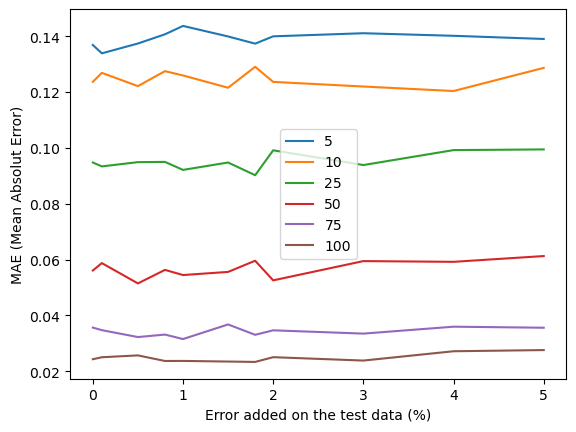

In [20]:
plot_pearson_error_master(mse_list_error_global, [5, 10, 25, 50, 75, 100])